Project options

- Credit card fraud detection
- 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
import warnings
from pyspark.sql.functions import col, expr
warnings.filterwarnings("ignore")

# Acquire

In [2]:
# reading data from csv stored in local file
df = pd.read_csv('creditcard.csv')

In [3]:
# taking a peek at the data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# looking at the Time column to get an idea of what values are here
df.Time.sample(20)

120736     75942.0
140366     83682.0
193102    129991.0
223846    143548.0
151744     96158.0
50254      44410.0
96488      65793.0
108144     70785.0
190112    128691.0
19153      30053.0
142283     84631.0
5706        5990.0
89366      62546.0
105719     69660.0
115137     73760.0
61156      49690.0
28372      34976.0
167100    118485.0
66684      52169.0
48388      43619.0
Name: Time, dtype: float64

- Time = Number of seconds elapsed between this transaction and the first transaction in the dataset
- so with this definition I think I will need to resample eventually to see a broader picture of what is going on
- do I drop the columns I don't know what the values mean?


In [5]:
df.shape

(284807, 31)

# Prepare

In [6]:
df.info

<bound method DataFrame.info of             Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  

<AxesSubplot:xlabel='Time'>

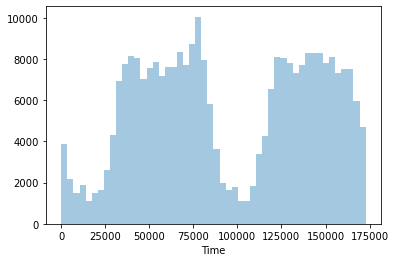

In [7]:
# Plot the histogram using the distplot function
sns.distplot( a=df["Time"], hist=True, kde=False, rug=False )

<AxesSubplot:xlabel='Amount'>

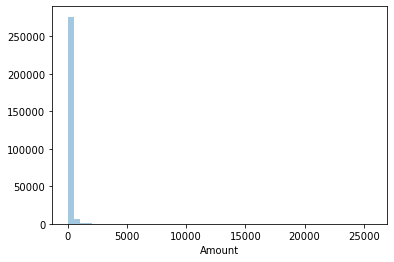

In [8]:
# Plot the histogram using the distplot function
sns.distplot( a=df["Amount"], hist=True, kde=False, rug=False )

<AxesSubplot:xlabel='Class', ylabel='Amount'>

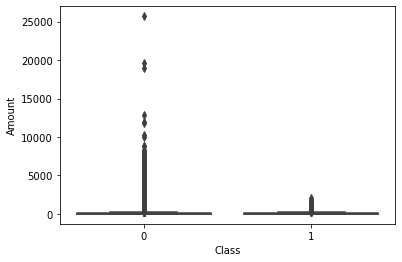

In [9]:
# creating a boxplot to look for outliers in Amount
sns.boxplot( x=df["Class"], y=df["Amount"] )

- consider handling outliers in Amount columnn to see what distribution looks like

In [10]:
# def get_upper_outliers(s, k):
#     '''
#     Given a series and a cutoff value, k, returns the upper outliers for the
#     series.

#     The values returned will be either 0 (if the point is not an outlier), or a
#     number that indicates how far away from the upper bound the observation is.
#     '''
#     q1, q3 = s.quantile([.25, .75])
#     iqr = q3 - q1
#     upper_bound = q3 + k * iqr
#     return s.apply(lambda x: max([x - upper_bound, 0]))

# def add_upper_outlier_columns(df, k):
#     '''
#     Add a column with the suffix _outliers for all the numeric columns
#     in the given dataframe.
#     '''
#     # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
#     #                 for col in df.select_dtypes('number')}
#     # return df.assign(**outlier_cols)

#     for col in df.select_dtypes('number'):
#         df[col + '_outliers'] = get_upper_outliers(df[col], k)

#     return df

# add_upper_outlier_columns(df, k=1.5)

# df.head()

In [11]:
# viewing the details on the outliers in each column
outlier_cols = [col for col in df if col.endswith('_outliers')]
for col in outlier_cols:
    print('~~~\n' + col)
    data = df[col][df[col] > 0]
    print(data.describe())

In [12]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

- Class = 1 for fraudulent transactions, 0 otherwise

In [13]:
import datetime as dt

seconds = df.Time

start = dt.datetime(2013,9,1,0,0) # You need a reference point

time_series = seconds.apply(lambda x: start + pd.Timedelta(seconds=x)).dt.time
time_series.head()

0    00:00:00
1    00:00:00
2    00:00:01
3    00:00:01
4    00:00:02
Name: Time, dtype: object

In [14]:
time_series = pd.DataFrame(time_series)
time_series

,Time
0,00:00:00
1,00:00:00
2,00:00:01
3,00:00:01
4,00:00:02
...,...
284802,23:59:46
284803,23:59:47
284804,23:59:48
284805,23:59:48


In [15]:
# can't get this one to work so Im trying spark 
# add time_series as a column to the df
#DataFrame.add(other, axis='columns', level=None, fill_value=None)
#df.add(time_series, axis='columns', level=None, fill_value=None)

In [16]:
# concatenate time_series series into df and replace seconds column
# df.append(time_series, ignore_index=True)

In [17]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [18]:
# checking for missing values
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

### Splitting the dataset into train and test

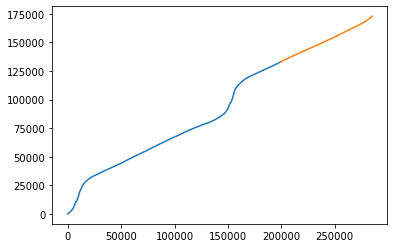

In [19]:
# splitting the dataset with a percentage based method for time 
# series data

train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.Time)
plt.plot(test.index, test.Time)

In [20]:
# the second split
# create X & y version of train, where y is a series with just the target variable and X are all the features. 

X_train = train.drop(columns=['Class'])
y_train = train.Class

X_test = test.drop(columns=['Class'])
y_test = test.Class

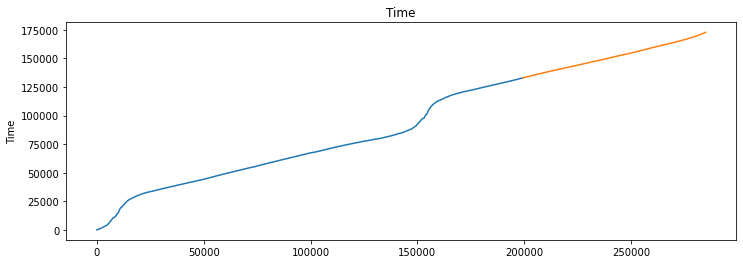

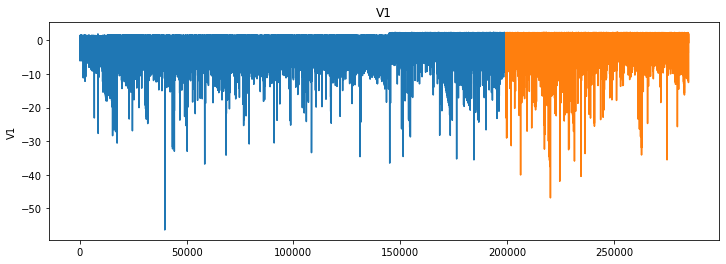

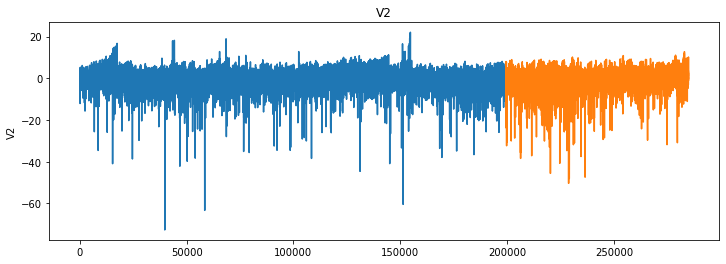

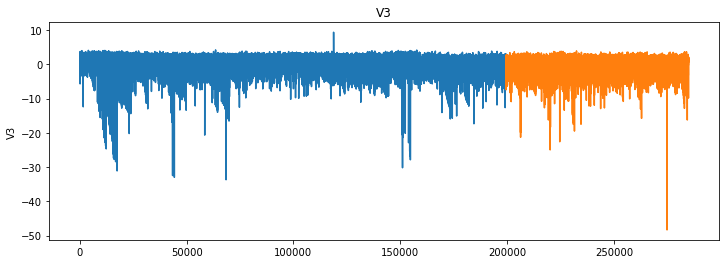

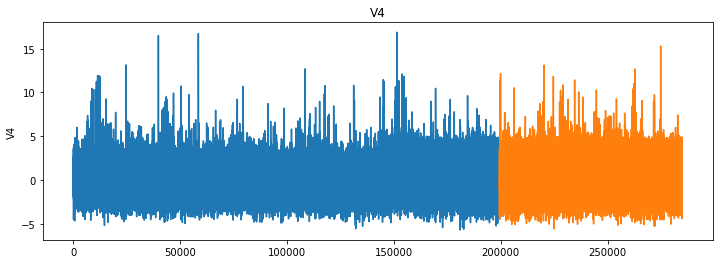

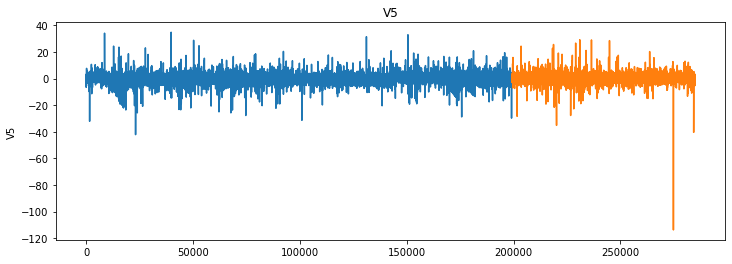

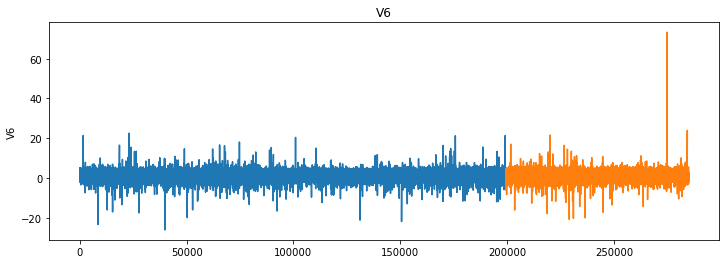

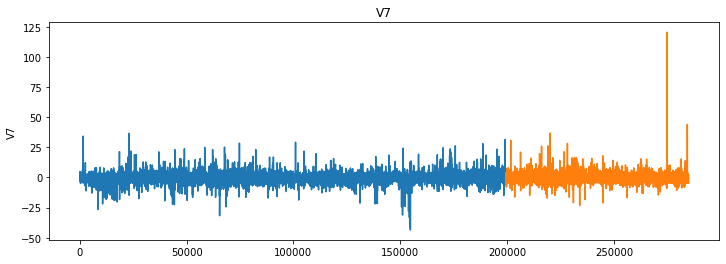

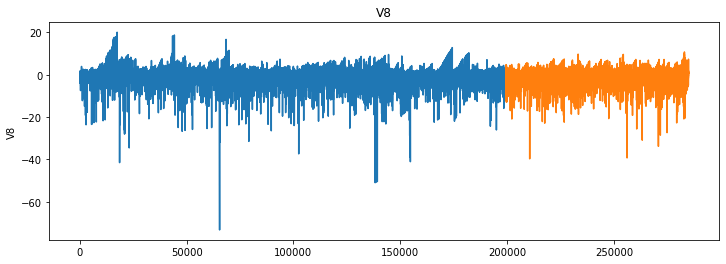

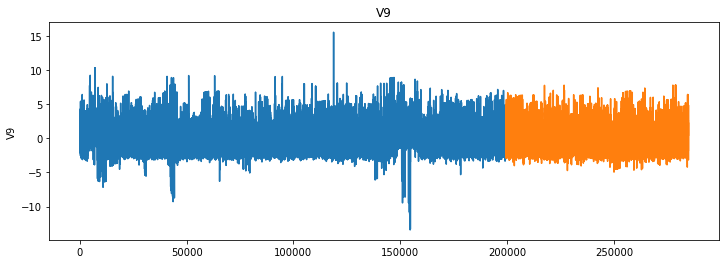

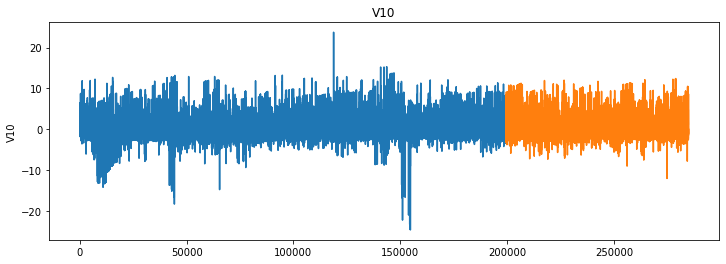

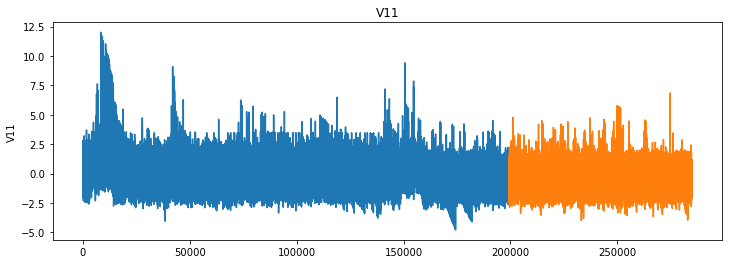

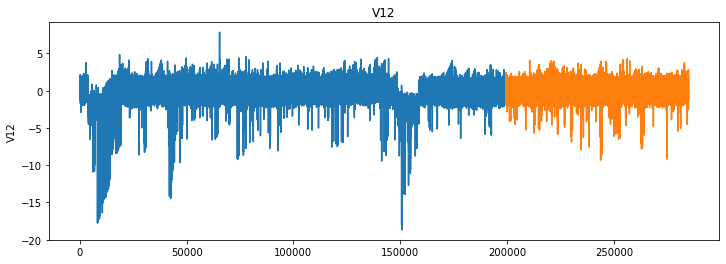

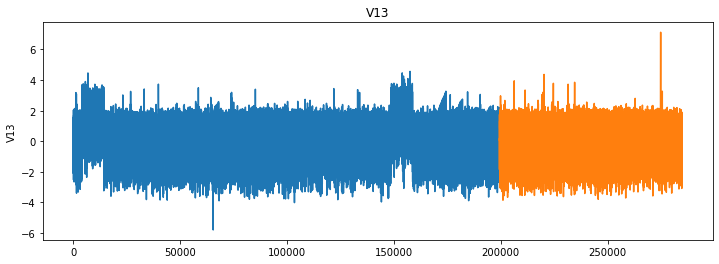

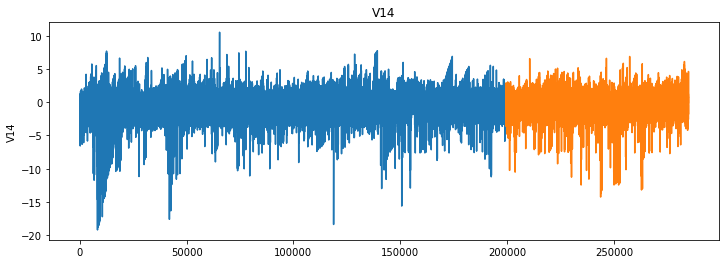

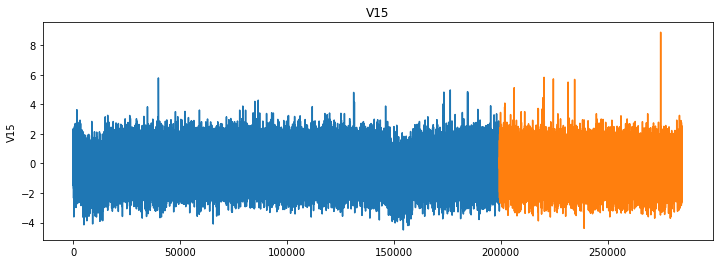

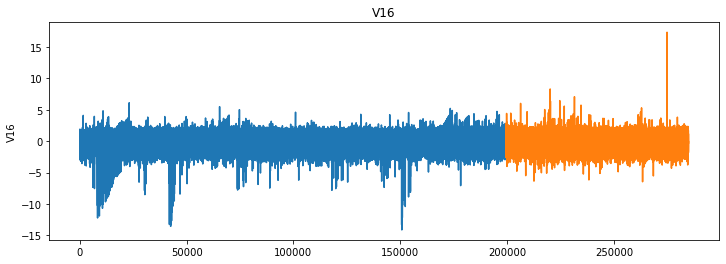

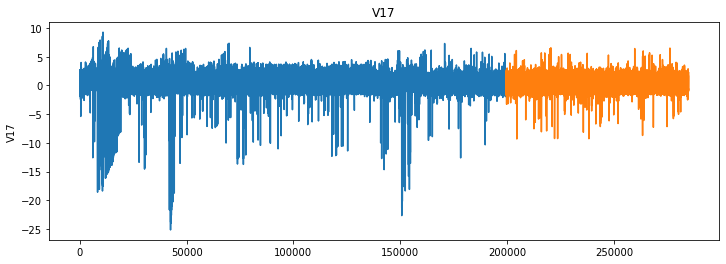

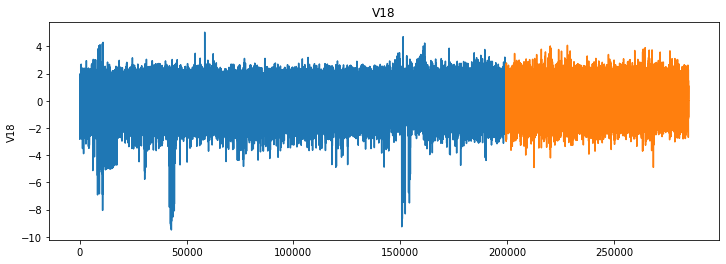

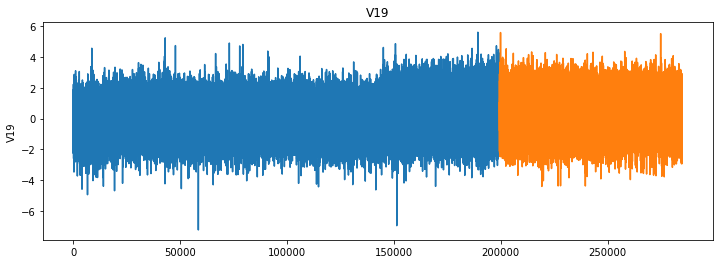

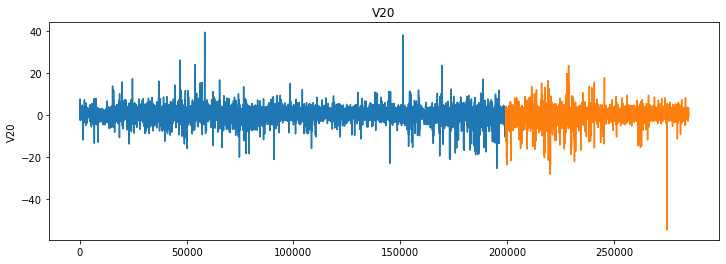

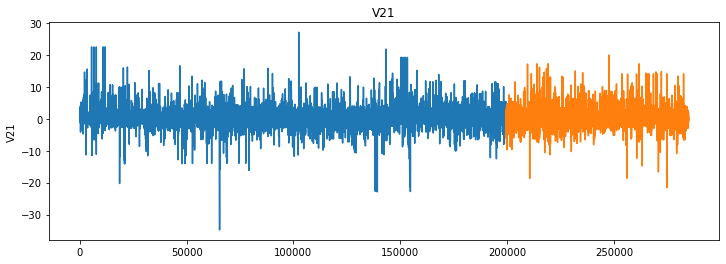

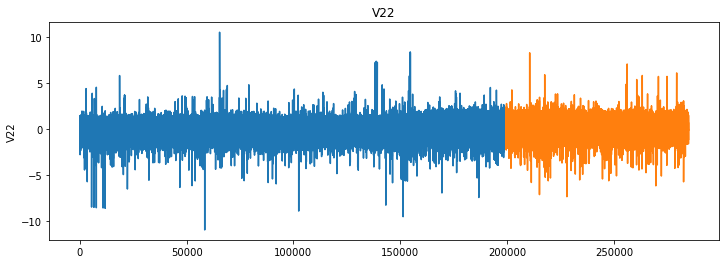

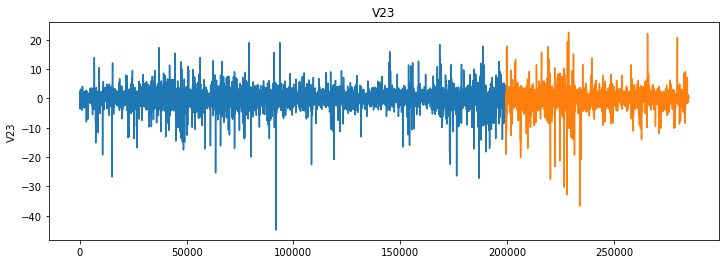

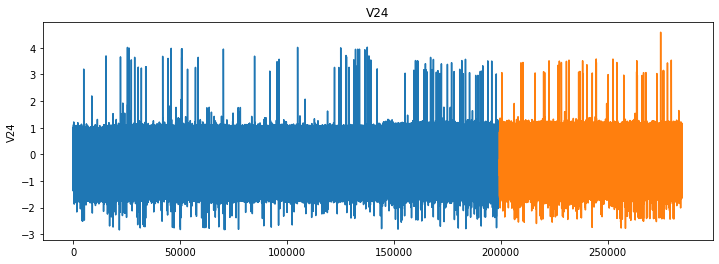

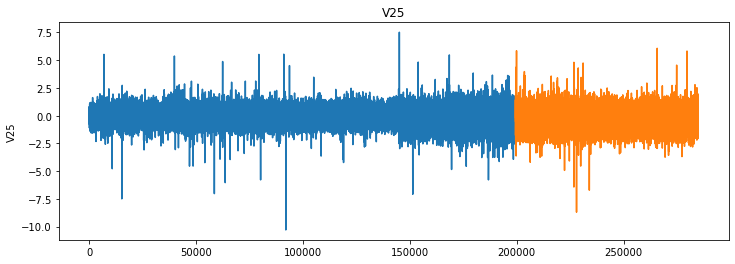

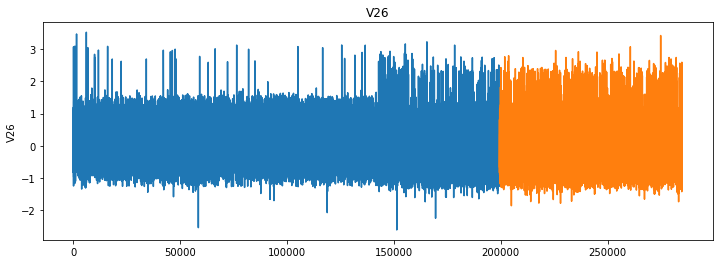

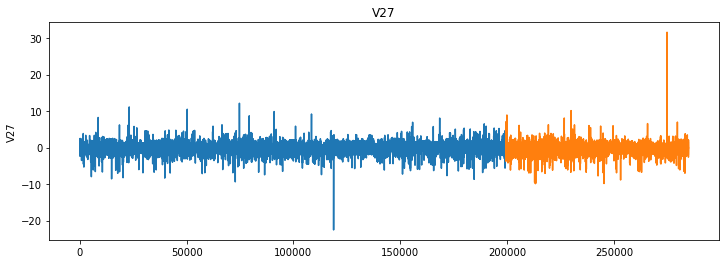

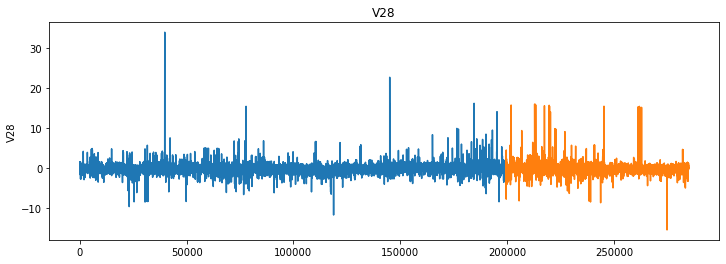

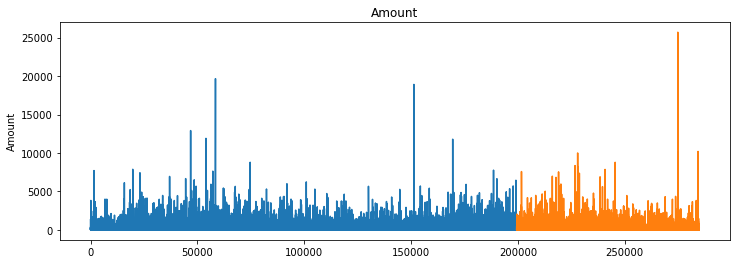

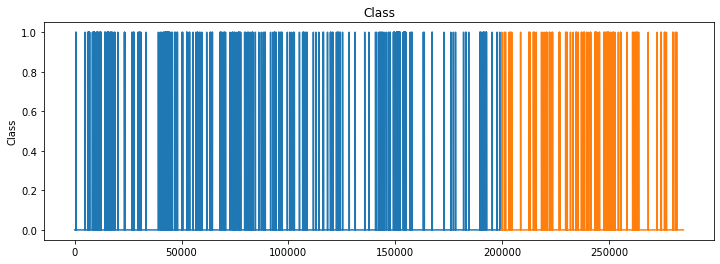

In [21]:
# taking a look at the train test data split
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

### Scaling the dataset for modeling

Text(0.5, 1.0, 'Scaled')

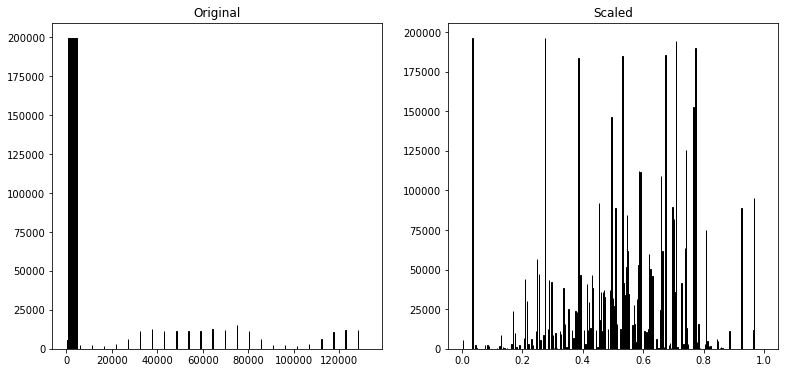

In [22]:
# using the MinMax Scaler scale the dataset
scaler = sklearn.preprocessing.MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.hist(X_train, bins=25, ec='black')
plt.title('Original')
plt.subplot(122)
plt.hist(X_train_scaled, bins=25, ec='black')
plt.title('Scaled')

In [23]:
# create a new spark session
import pyspark

spark = pyspark.sql.SparkSession.builder.getOrCreate()

# convert the pandas dataframe to a spark dataframe
df = spark.createDataFrame(df)
df

df.show(5)

+----+------------------+-------------------+----------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+-------------------+------+-----+
|Time|                V1|                 V2|              V3|                V4|                 V5|                 V6|                 V7|                V8|                V9|                V10|               V11|               V12|               V13|               V14|               V15|               V16|               V17|                V18|               V19|                V20|                V21|               V22|          

In [24]:
# choosing to look at just three features for a moment
df.select(df.Time, df.Amount, df.Class).show(10)

+----+------+-----+
|Time|Amount|Class|
+----+------+-----+
| 0.0|149.62|    0|
| 0.0|  2.69|    0|
| 1.0|378.66|    0|
| 1.0| 123.5|    0|
| 2.0| 69.99|    0|
| 2.0|  3.67|    0|
| 4.0|  4.99|    0|
| 7.0|  40.8|    0|
| 7.0|  93.2|    0|
| 9.0|  3.68|    0|
+----+------+-----+
only showing top 10 rows



In [25]:
df.select(
        expr("Time / 60 AS Minutes"),
        expr("Time / 360 AS Hours"),
        expr("Amount"),
        expr("Class")
).show(10)

+--------------------+--------------------+------+-----+
|             Minutes|               Hours|Amount|Class|
+--------------------+--------------------+------+-----+
|                 0.0|                 0.0|149.62|    0|
|                 0.0|                 0.0|  2.69|    0|
|0.016666666666666666|0.002777777777777778|378.66|    0|
|0.016666666666666666|0.002777777777777778| 123.5|    0|
| 0.03333333333333333|0.005555555555555556| 69.99|    0|
| 0.03333333333333333|0.005555555555555556|  3.67|    0|
| 0.06666666666666667|0.011111111111111112|  4.99|    0|
| 0.11666666666666667|0.019444444444444445|  40.8|    0|
| 0.11666666666666667|0.019444444444444445|  93.2|    0|
|                0.15|               0.025|  3.68|    0|
+--------------------+--------------------+------+-----+
only showing top 10 rows



### Prepare Takeaways
- Time is has a bimodal distribution
- I investigated the outliers in each column and for this MVP run through I will do a version with outliers included for this draft and then do a version with outliers removed 
- wanted to turn df into datetime for time series analysis but did not have computing power to do so kernel died each time
- next I tried turning the df into a spark df to see if I could manipulate the time series data that way but with no luck
- no nulls to deal with
- Split dataset into train and test by percentage 
- Data was scaled using the MinMax Scaler
- need to deal with the imbalanced data in target- might use Smote Tomek in modeling to rectify this

# Explore

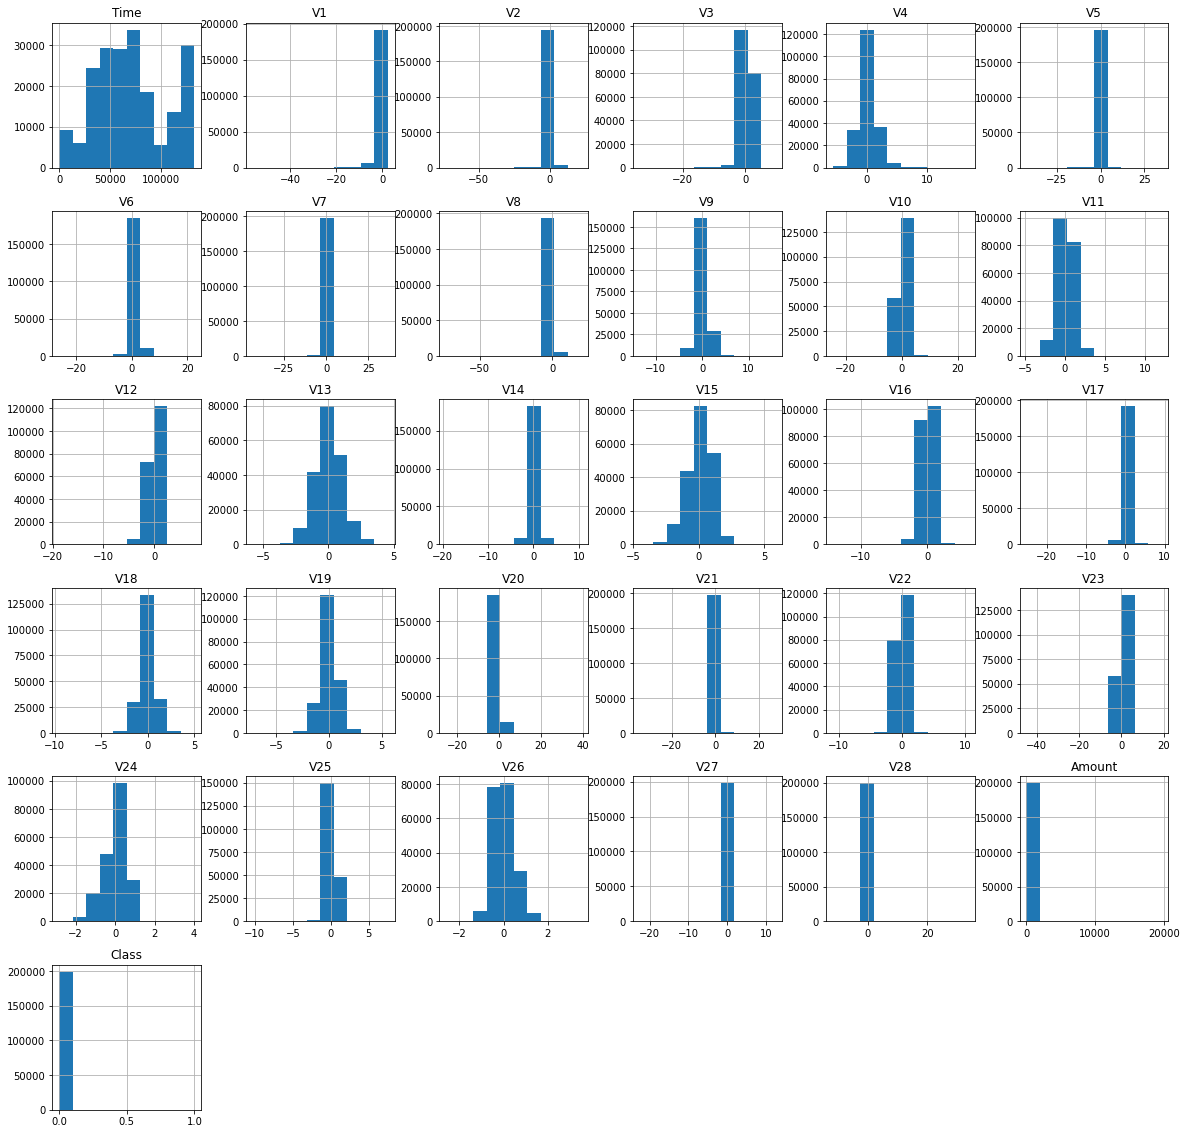

In [27]:
# plotting histograms for each column
train.hist(figsize=(20,20))
plt.show()

In [ ]:
# attempting to write a loop to look at the plot for each column
for col in train:
    train[col].plot(figsize = (40,10))
plot.show()

In [ ]:
train["Time"].plot(figsize = (40,10))

In [ ]:
train.head()

In [ ]:
# fraud
train["Amount"][train["Class"] == 1].plot(figsize = (40,10))
plt.show()

In [ ]:
# legitimate transaction
train["Amount"][train["Class"] == 0].plot(figsize = (40,10))
plt.show()

In [ ]:
3,600 seconds in an hour
86,400 seconds in a day

In [ ]:
train["V1"].plot(figsize = (40,10))
plt.show()

### The plan
- looks like some resampling should be done to get a broader picture- did this with spark but haven't figured how to visualize this
- let's create some visuals in Tableau to expand our options
- hone in on which are the key drivers
  - stats tests
  - feature elimination methods
  - use visuals to guide this exploration
 

# Modeling

In [ ]:
# evaluation function to compute rmse

def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [ ]:
# go back to modeling section of time series
#

Suggestions:
    For starters, I recommend you try variants of the following.1. Aggregate the usage data by hours/days. 2. From your training data, overlay plots of these time-series to see patterns within the two groups. 3. Explore various time-series/regression models that fit your data well. 4. Use the model coefficients as features for your classifier.

Another suggestion from cgi co worker: Try to get the datetime format you want set up with just 20 rows or so. Bring in a csv with only 20 rows and see if you can get that to transform correctly if so then move on to trying to make that work in spark.
    
    
Something I learned about time series
    That the train data too far from test will not predict well so I should use the train data to predict on short increments in comparison to the entire time, in my case 2 days so I might try to predict 2 hours out